In [ ]:
from Python.tigre.utilities.io.VarianDataLoader import (
    read_scatter_calib,get_xmlns,load_blank_projections,read_varian_geometry, 
    VarianDataLoader,load_projections, calculate_angular_threshold, correct_detector_scatter,
    calculate_dps_kernel, read_dps_params
)
from scipy.ndimage import median_filter
from scipy.signal import decimate, convolve2d
from scipy.interpolate import RegularGridInterpolator
from Python.tigre.algorithms.single_pass_algorithms import FDK
from Python.tigre import plotimg
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mydir = "C:/CBCT_Scatter_Removal_Project/data/clinical/4100758/2021-07-06_101037/11528a87-b894-4239-846d-45d8fd1efeda"

In [ ]:
geometry, scan_params = read_varian_geometry(mydir)
sc_calib = read_scatter_calib(mydir)
blank_projs,blank_angles,blank_airnorms = load_blank_projections(mydir,scan_params)

In [ ]:
ns = get_xmlns(scan_params)
rot_velocity = float(scan_params.find("Acquisitions/Velocity", ns).text)
frame_rate = float(scan_params.find("Acquisitions/FrameRate", ns).text)
angular_threshold = calculate_angular_threshold(rot_velocity, frame_rate)
projs, angles, airnorms = load_projections(mydir,angular_threshold)

In [ ]:
def get_detector_coords_cm(geometry, downsample_rate=0):
    # Detector coords,centered (cm)
    us = 0.1 * (
        0.5
        * (geometry.sDetector[1] - geometry.dDetector[1])
        * np.linspace(-1, 1, int(geometry.nDetector[1]))
    )
    vs = 0.1 * (
        0.5
        * (geometry.sDetector[0] - geometry.dDetector[0])
        * np.linspace(-1, 1, int(geometry.nDetector[0]))
    )

    if downsample_rate:
        us = decimate(us, downsample_rate)
        vs = decimate(vs, downsample_rate)

    return us, vs


In [ ]:
# Detector coords,centered (cm)
from scipy.interpolate import interpn

us, vs = get_detector_coords_cm(geometry)
U, V = np.meshgrid(us, vs, indexing='ij')

# Downsampled coords
dus, dvs = get_detector_coords_cm(geometry, downsample_rate=8)
DU, DV = np.meshgrid(dus, dvs, indexing='ij')

# Detector point scatter kernel
det_kernel = calculate_dps_kernel(sc_calib, DU, DV)

# Interpolate
proj_down = interpn((us, vs), projs[0],(DU,DV))
scatter_down = convolve2d(proj_down, det_kernel, mode="same")
scatter = interpn((dus,dvs),scatter_down,(U,V), method='cubic',bounds_error=False,fill_value=None)

In [ ]:
### Scatter Correction block. Args: (ScCalib, Blk, BlkAirNorm, proj, airnorm, geo)
DOWNSAMPLE = 12
# Detector coords,centered (cm)
us, vs = get_detector_coords_cm(geometry)
U, V = np.meshgrid(us, vs,indexing='ij')

# Downsampled coords
dus, dvs = get_detector_coords_cm(geometry, downsample_rate=DOWNSAMPLE)
DU, DV = np.meshgrid(dus, dvs,indexing='ij')

ns = get_xmlns(sc_calib)
obj_scatter_models = sc_calib.find("CalibrationResults/ObjectScatterModels", ns)
thickness_bounds = [float(thickness.text) for thickness in obj_scatter_models.findall("ObjectScatterModel/Thickness",ns)]

In [ ]:
def calculate_grid_response(us,vs, grid_efficiency):
    K = -0.15  # TODO: determine where this number is in the cited article
    B = 1
    t_ratio = K*abs(vs.T) + B
    kernel = np.tile(t_ratio[:,np.newaxis],[1,len(us)])
    kernel[kernel<grid_efficiency] = grid_efficiency
    return kernel

In [ ]:
efficiency = float(obj_scatter_models.find("ObjectScatterModel/GridEfficiency/LamellaTransmission",ns).text)
k_grid = calculate_grid_response(dus,dvs,efficiency)

# object model weights
gamma = float(obj_scatter_models.find("ObjectScatterModel/ObjectScatterFit/gamma",ns).text)

# optimization parameters
num_iter = 1
lam = 0.005 # relaxation factor

In [ ]:
def estimate_water_equiv_thickness(blank, proj, mu_water):
    ratio = blank/(proj)
    ratio[ratio<0] = 0
    log_norm = np.log(ratio)
    thickness = log_norm / mu_water
    # TODO: correct for NaNs?
    return thickness

from scipy.ndimage import gaussian_filter


def smooth_thickness(thickness, sigma):
    return gaussian_filter(thickness, sigma)


def get_thickness_masks(thickness,thickness_bounds):
    mask = np.zeros_like(thickness)
    masks = np.tile(mask[np.newaxis,:,:],[len(thickness_bounds),1,1])
    for i in range(len(thickness_bounds)-1):
        masks[i] = (thickness>thickness_bounds[i]) * (thickness<thickness_bounds[i+1])
    masks[-1] = thickness>thickness_bounds[-1]
    return masks


def get_form_func_params(obj_scatter_models):
    obj_scatter_fits = obj_scatter_models.findall("ObjectScatterModel/ObjectScatterFit",ns)
    # for i in range(obj_scatter_fits):
    sigma1 = [float(elem.find("sigma1",ns).text) for elem in obj_scatter_fits]  # (cm^-1)
    sigma2 = [float(elem.find("sigma2",ns).text) for elem in obj_scatter_fits]  # (cm^-1)
    B = [float(elem.find("B",ns).text) for elem in obj_scatter_fits]
    return sigma1,sigma2,B


def calculate_form_functions(thickness,obj_scatter_models,grid_coords):
    sigma1,sigma2,B = get_form_func_params(obj_scatter_models)
    U,V = grid_coords
    grid = U**2 + V**2
    gform = np.zeros_like(thickness)
    gforms = np.tile(gform[np.newaxis,:,:],[len(thickness_bounds),1,1])

    for i in range(len(thickness_bounds)):
        gforms[i] = np.exp(-0.5*grid / (sigma1[i]**2)) + B[i]*np.exp(-0.5*grid/(sigma2[i]**2))
    return gforms


def calculate_edge_response(thickness):
    threshold = 50
    filter_size = 25
    num_iter = 5
    edge_weight = thickness>threshold
    edge_weight = np.array(edge_weight,dtype='float')
    tmp_mask = edge_weight
    avg_kernel = np.ones(filter_size)/filter_size
    # TODO fix
    edge = edge_weight.copy()
    for i in range(num_iter):
        edge = np.convolve(edge,avg_kernel,mode='same')
    tmp = tmp_mask*edge_weight
    min_val = 0.6
    edge_weight = (1-min_val)*(tmp - tmp.min())/(tmp.max() - tmp.min()) + min_val
    return edge_weight




In [281]:
mu_water = float(sc_calib.find("CalibrationResults/Globals/muH2O",ns).text)

In [282]:
i=0  # TODO: replace with loop over all projections

# TODO: matlab version uses sum of all blank scans, could instead use the interpolated scan for v2.7
CF = blank_airnorms[0]/airnorms[i]
blank = interpn((us,vs),blank_projs[0]/CF,(DU,DV))
proj = interpn((us,vs),projs[i],(DU,DV))
Is = np.zeros(np.shape(proj))  # initialize scatter 

# Get smoothing stdevs
sigma_u = float(sc_calib.find('CalibrationResults/Globals/AsymPertSigmaMMu',ns).text)
sigma_v = float(sc_calib.find('CalibrationResults/Globals/AsymPertSigmaMMv',ns).text) 

step_du = np.mean(np.diff(dus))
step_dv = np.mean(np.diff(dvs))
mm2cm = lambda x: 0.1*x
sigma = (mm2cm(sigma_u)/step_du, mm2cm(sigma_v)/step_dv)

for n in range(num_iter):
    Is_old = Is
    thickness = estimate_water_equiv_thickness(blank, proj, mu_water)
    thickness = smooth_thickness(thickness,sigma)
    thickness_masks = get_thickness_masks(thickness,thickness_bounds)
    gforms = calculate_form_functions(thickness,obj_scatter_models,(DU,DV))
    edge_weight = calculate_edge_response(thickness)


ValueError: object too deep for desired array

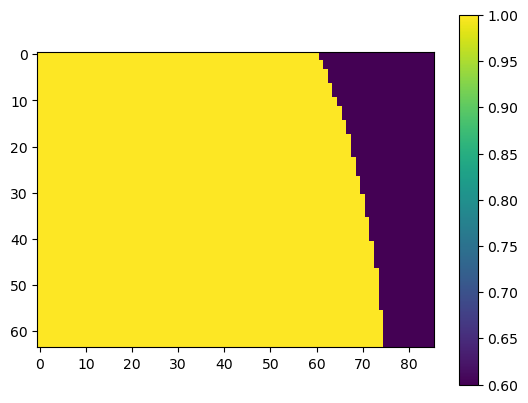

In [283]:
plt.imshow(edge_weight)
plt.colorbar()

In [ ]:
log_projs,geo,angles = VarianDataLoader(filepath=mydir,acdc=1,dps=0,sc=0)

In [ ]:
recon = FDK(log_projs,geo,angles)
recon = enforce_positive(recon)